In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# System:
import os
import re
import csv
import gzip
import time
import datetime
import sys
import gc
import six.moves.cPickle as pickle
import cProfile
import itertools
from tqdm import tqdm, tqdm_notebook
from IPython import get_ipython
ipython_shell = get_ipython()

# Math 
import scipy.stats as st
import numpy as np
from scipy.cluster import hierarchy as sch

# Plotting:
import matplotlib.pyplot as plt
from matplotlib import gridspec, ticker, markers
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from IPython import display
import igraph
from polo import optimal_leaf_ordering
from scipy import sparse

# Local paths and functions:
import process_ML as LOAD
import auxfunc_masterlist as AUX

# For random data:
rng = np.random

In [90]:
mark = 'DNase-seq'
# mark = 'H3K4me3'
# mark = 'H3K4me1'
# mark = 'H3K27ac'
base = 'alltracks'
imgpref = '/home/cboix/EPIMAP_ANALYSIS/img/ML_statistics/'
obj = LOAD.process_ML(mark, base)

In [91]:
obj.load_data()
obj.load_info()
obj.load_annotation()

[STATUS] Loaded data with shape (imputed): (5148424, 865) and (observed): (5148424, 865)
[STATUS] Keeping 3180009 peaks with evidence > 2
[STATUS] Read in 5148425 infolines
[STATUS] Read in 916 infolines
[STATUS] Read in 681 points for dendrogram subsets


/home/cboix/EPIMAP_ANALYSIS/bin/process_ML.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.ann.sex[ind] = 'unknown/mix'
/home/cboix/EPIMAP_ANALYSIS/bin/process_ML.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.ann.lifestage[ind] = 'unknown/mix'


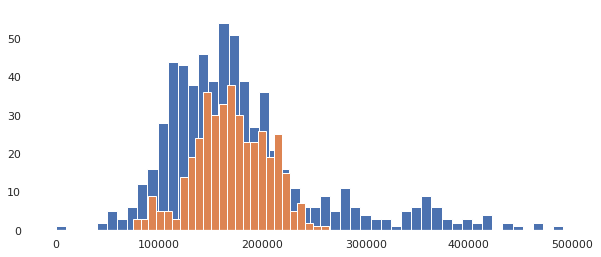

In [92]:
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.set_facecolor('white')
sns.set(font_scale=1)
if mark == 'DNase-seq':
    h = plt.hist(obj.co[obj.co > 0], bins=50)
    h = plt.hist(obj.ci[obj.ci > 0], bins=25)
else:
    h = plt.hist(obj.ci[obj.ci > 0], bins=50)
    h = plt.hist(obj.co[obj.co > 0], bins=40)
fig = plt.gcf()
fig.savefig(imgpref + 'ncounts_' + mark + '.png', bbox_inches='tight', dpi=300)

In [93]:
obj.get_mix_jaccard()

/home/cboix/miniconda3/lib/python3.6/site-packages/scipy/sparse/base.py:594: RuntimeWarning: divide by zero encountered in true_divide
  return np.true_divide(self.todense(), other)
/home/cboix/miniconda3/lib/python3.6/site-packages/scipy/sparse/base.py:594: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


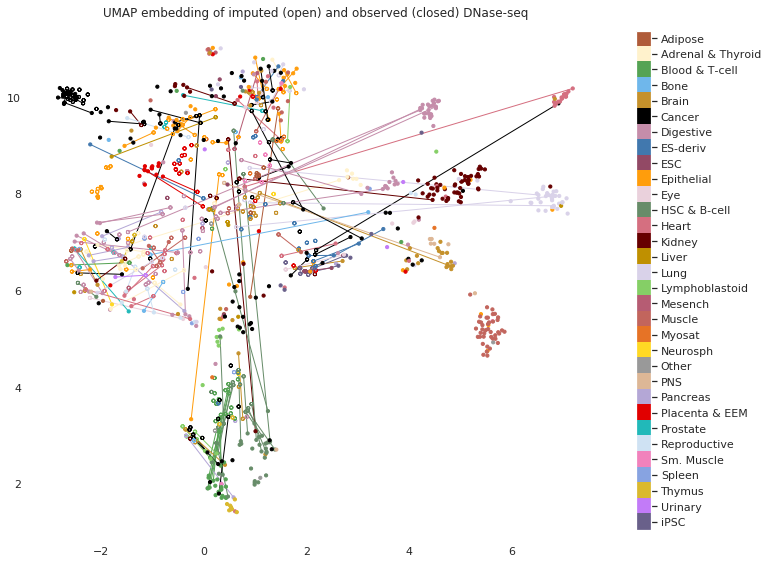

In [94]:
NN = 100;  MD = 0.25;
fig = obj.plot_mix_umap(n_neighbors=NN, min_dist=MD, size=10, seed=1, add_bkline=0)
fig.savefig(imgpref + 'MDS_' + mark + '_ioline.png', bbox_inches='tight', dpi=300)

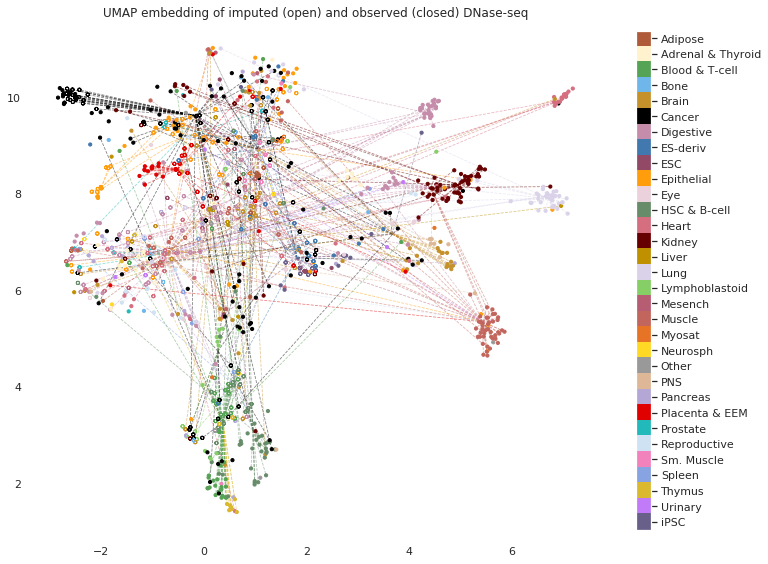

In [95]:
fig = obj.plot_mix_umap(n_neighbors=NN, min_dist=MD, size=10, seed=1, add_ioline=0)
fig.savefig(imgpref + 'MDS_' + mark + '_bkline.png', bbox_inches='tight', dpi=300)

In [96]:
for color in ['group', 'sex', 'lifestage', 'type']:
    print("[STATUS] Plotting by " + color + " ... ")
    fig = obj.plot_mix_umap(n_neighbors=NN, min_dist=MD, size=10, 
                            seed=1, add_bkline=0, colorby=color, show=False)
    print("[STATUS] Saving figure...")
    fig.savefig(imgpref + 'MDS_' + mark + '_' + color + '_ioline.png', bbox_inches='tight', dpi=300)
    plt.close(fig)

[STATUS] Plotting by group ... 
[STATUS] Saving figure...
[STATUS] Plotting by sex ... 
[STATUS] Saving figure...
[STATUS] Plotting by lifestage ... 
[STATUS] Saving figure...
[STATUS] Plotting by type ... 
[STATUS] Saving figure...


In [99]:
import compress_bw_to_hd5py as CPH

In [169]:
cp = CPH.compress_bw(mark='DNase-seq', chrom='chr1')
cp.main()



  0%|          | 0/3 [00:00<?, ?it/s]

[STATUS] Searching directory for files
[STATUS] There are 3 prefixes of files matching chr1_impute_*DNase-seq*.wig.gz
[STATUS] Processing files
[STATUS] Processing chr1




 33%|███▎      | 1/3 [00:00<00:01,  1.36it/s]

 67%|██████▋   | 2/3 [00:01<00:00,  1.38it/s]

100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

[STATUS] Exporting chr1_DNase-seq_imputed with shape (9970025, 3) to HDF5 dataset.


##  Read in files and evaluate how best to scale:

In [2]:
def read_bw(file):
    array = []
    with gzip.open(file, 'rt') as f:
        header1 = next(f)
        header2 = next(f)
        for line in f:
            line = line.strip("\n")
            array.append(float(line))
    narray = np.array(array)
    return(narray)

In [3]:
dbdir = '/home/cboix/EPIMAP_ANALYSIS/db/'
bwfiles = ['test_imp_scaling/chr9_FINAL_H3K27ac_BSS01601.sub_VS_FINAL_WCE_BSS01601.pval.signal.bedgraph.gz.wig.gz',
'test_imp_scaling/chr9_impute_BSS01601_H3K27ac.wig.gz',
'test_imp_scaling/chr9_FINAL_H3K27ac_BSS01676.sub_VS_FINAL_WCE_BSS01676.pval.signal.bedgraph.gz.wig.gz',
'test_imp_scaling/chr9_impute_BSS01676_H3K27ac.wig.gz']

In [4]:
ad = {}
for i in range(len(bwfiles)):
    file = dbdir + bwfiles[i]
    out = read_bw(file)
    ad[i] = out
    print(str(i) + " : " + str(len(out)))

0 : 5648538
1 : 5648538
2 : 5648538
3 : 5648538


In [130]:
def plot_bw(array, start, size, color='black', lim=None):
    y = array[int(start):int(start + size)]
    plt.plot(y, color=color)
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.fill_between(range(len(y)), 0, y, color=color) 
    if lim is not None:
        plt.ylim(lim)

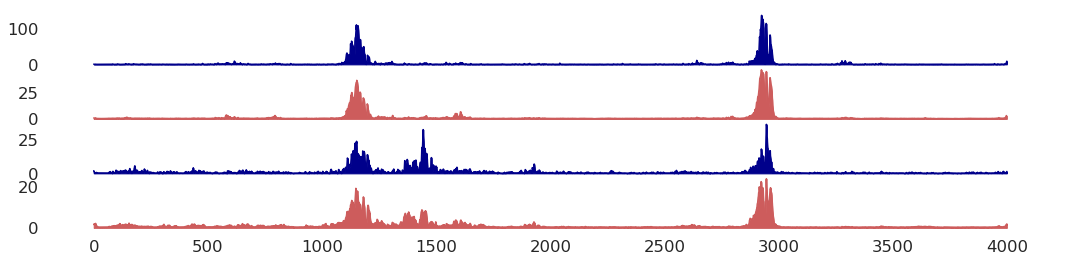

In [131]:
N = len(bwfiles)
plt.figure(figsize=(18,N * 1))
gs = gridspec.GridSpec(N, 1, hspace=0.01)
size = 4e3
for i in range(N):
    plt.subplot(gs[i])
    if i % 2 == 0:
        fig = plot_bw(ad[i], 1e6 + 1e5, size, color='darkblue')
    else:
        fig = plot_bw(ad[i], 1e6 + 1e5, size, color='indianred')

In [136]:
start = int(1.5e4)
size = 2e4
lim = 20
    
def plot_diff(x1, x2, start, size, lim=20):
    plt.figure(figsize=(18, 3 * 1))
    gs = gridspec.GridSpec(3, 1, hspace=0.05, height_ratios=[1,1,2])

    
    plt.subplot(gs[0])
    fig = plot_bw(x1, start, size, color='darkblue', lim=(0,lim))

    plt.subplot(gs[1])
    fig = plot_bw(x2, start, size, color='indianred', lim=(0,lim))

    plt.subplot(gs[2])
    diff = x1 - x2
    fig = plot_bw(diff, start, size, color='purple', lim=(-lim, lim))

In [216]:
dataset = 0
obs = ad[dataset]
imp = ad[dataset + 1]
slice = range(int(1e5))
def plot_ma(obs, imp, slice, cut2=True):
    x = obs[slice]
    y = imp[slice]
    #s2 = np.where(((x > 2) + (y > 2)) > 0)[0]
    s2 = np.where(((x > 2)) > 0)[0]
    if cut2:
        x2 = x[s2]
        y2 = y[s2]
    else:
        x2 = x
        y2 = y
        
    # Find the slope and intercept of the best fit line
    slope, intercept = np.polyfit(x2, y2, 1)
    rnx = [1,max(x)]
    rnx2 = [1,max(x)]
    abline_values = [slope * i + intercept for i in rnx]

    # Plot the best fit line over the actual values
    plt.figure(figsize=(24,6))
    gs = gridspec.GridSpec(1, 4)

    sns.set(font_scale=1.5)
    plt.subplot(gs[0])
    plt.plot(x2, y2, '.', alpha=0.1) 
    plt.ylabel('Imputed')
    plt.xlabel('Observed')
    ax = plt.gca()
    ax.set_facecolor("white")
    plt.plot(rnx, abline_values, 'g')
    plt.plot(rnx, rnx, 'r--')
    plt.title('Slope is ' + str(round(slope,3)))

    plt.subplot(gs[1])
    plt.loglog(x2, y2, '.', alpha=0.1) 
    plt.ylabel('Imputed')
    plt.xlabel('Observed')
    ax = plt.gca()
    ax.set_facecolor("white")
    plt.loglog(rnx, abline_values, 'g')
    plt.loglog(rnx2, rnx2, 'r--')
    plt.title('Slope is ' + str(round(slope,3)))


    plt.subplot(gs[2])
    # Plot the best fit line over the actual values
    plt.plot(x2 + y2, x2 - y2, '.', alpha=0.5) 
    plt.xlabel('Observed + Imputed')
    plt.ylabel('Observed - Imputed')
    ax = plt.gca()
    ax.set_facecolor("white")
    plt.plot([0, max(x2 + y2)], [0,0], 'r--')
    plt.title('MA plot - no scaling')

    plt.subplot(gs[3])
    # Plot the best fit line over the actual values
    plt.plot(x2 * slope + y2, x2 * slope - y2, '.', alpha=0.5) 
    plt.xlabel('Observed + Imputed')
    plt.ylabel('Observed - Imputed')
    ax = plt.gca()
    ax.set_facecolor("white")
    plt.plot([0, max(x2 * slope + y2)], [0,0], 'r--')
    plt.title('MA plot - scaled by slope')
    return(slope)

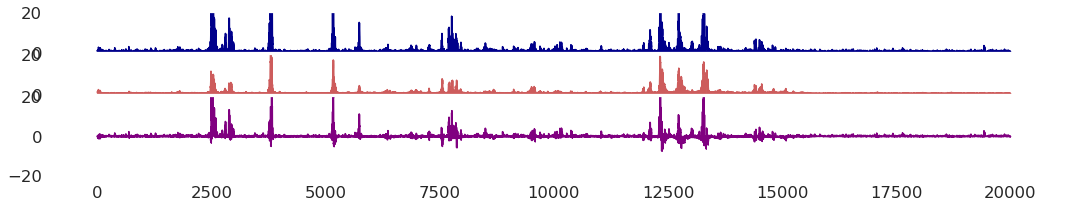

In [209]:
plot_diff(ad[0], ad[1], start, size)

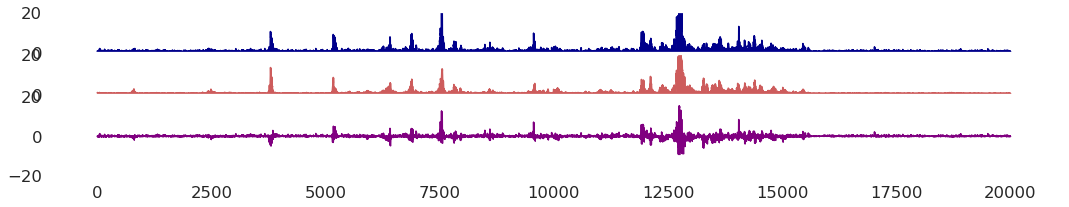

In [210]:
plot_diff(ad[2], ad[3], start, size)

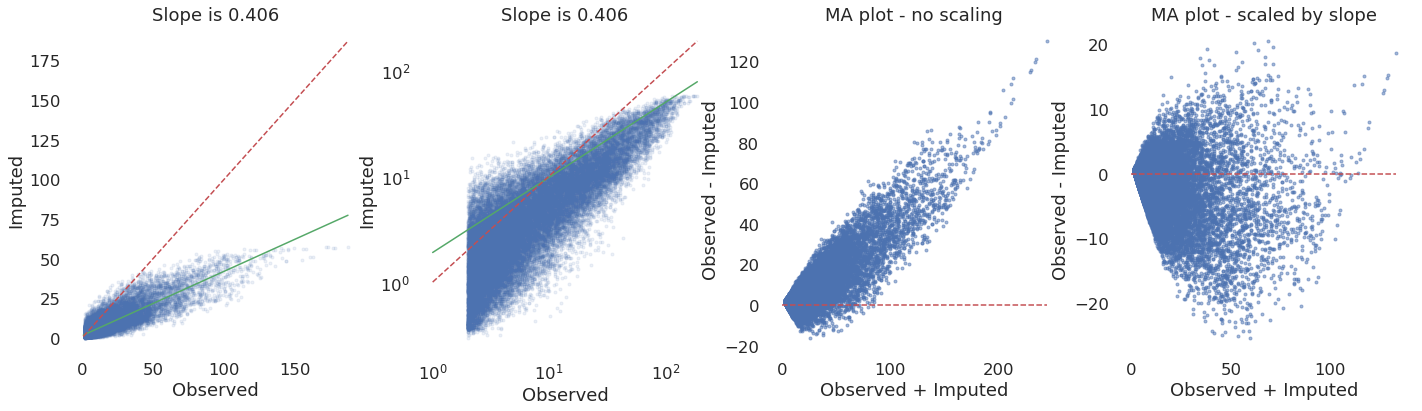

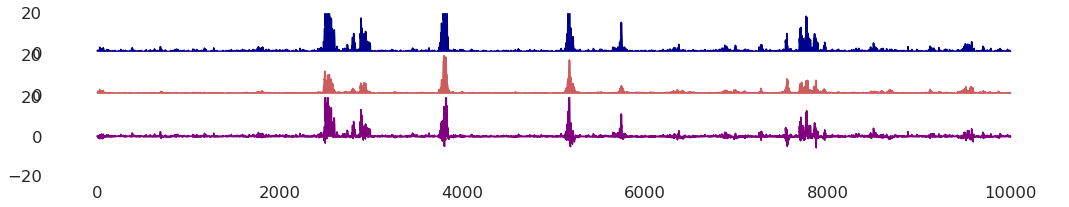

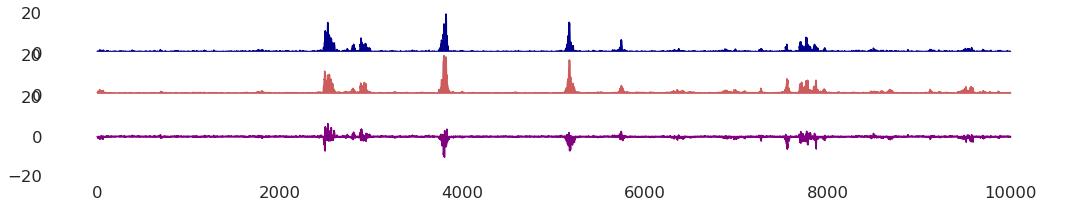

In [217]:
dataset = 0
obs = ad[dataset]
imp = ad[dataset + 1]
slope = plot_ma(obs, imp, range(int(2e6)))

plot_diff(obs, imp, start, 1e4, lim=20)
plot_diff(slope * obs, imp, start, 1e4, lim=20)

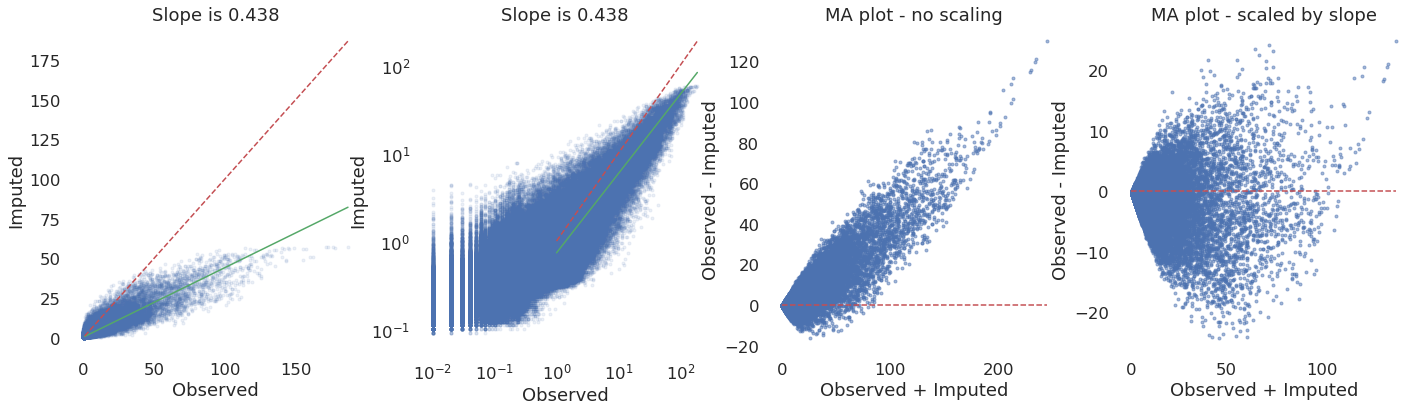

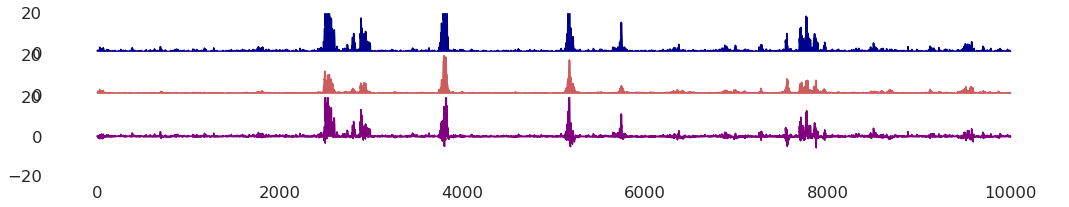

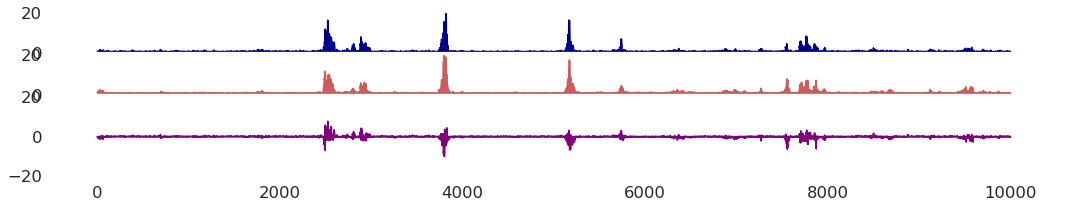

In [218]:
dataset = 0
obs = ad[dataset]
imp = ad[dataset + 1]
slope = plot_ma(obs, imp, range(int(2e6)), cut2=False)

plot_diff(obs, imp, start, 1e4, lim=20)
plot_diff(slope * obs, imp, start, 1e4, lim=20)

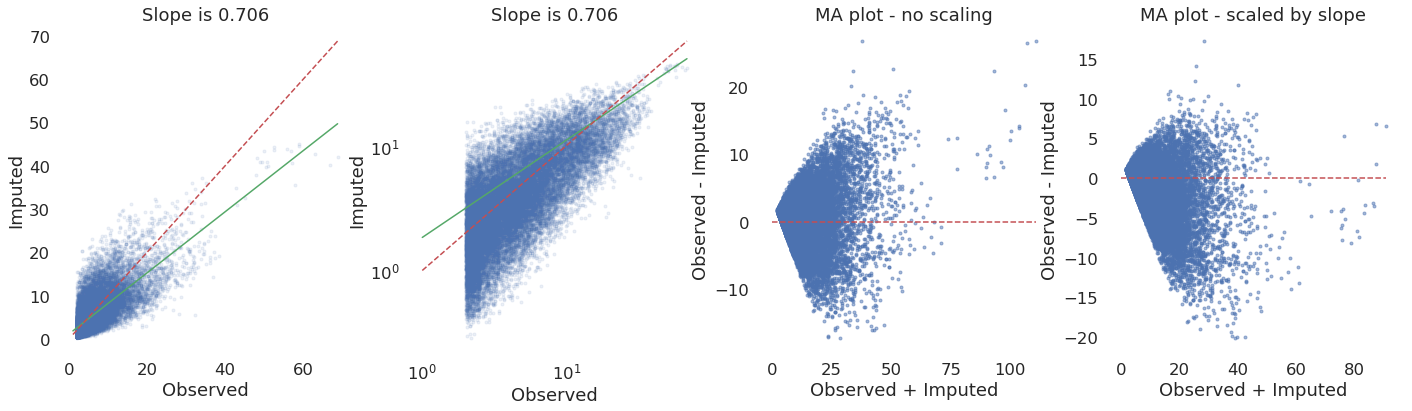

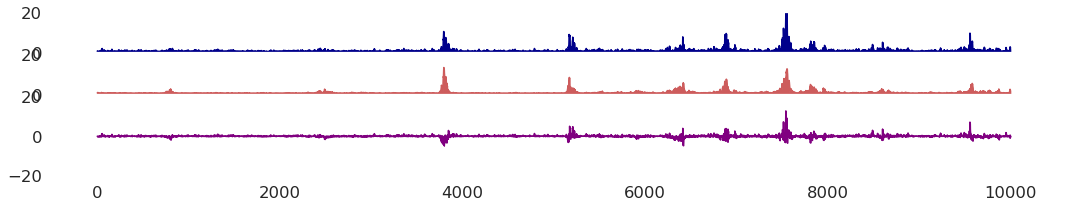

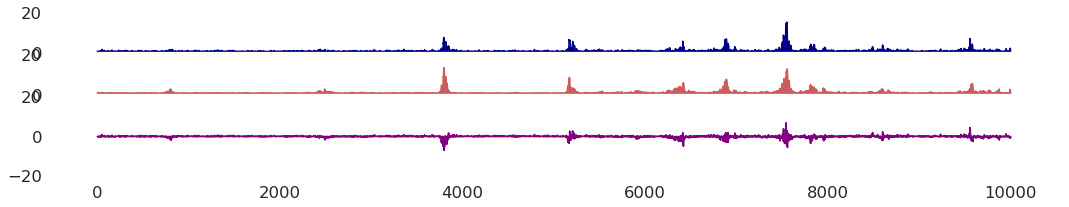

In [219]:
dataset = 2
obs = ad[dataset]
imp = ad[dataset + 1]
slope = plot_ma(obs, imp, range(int(2e6)))
plot_diff(obs, imp, start, 1e4, lim=20)
plot_diff(slope * obs, imp, start, 1e4, lim=20)

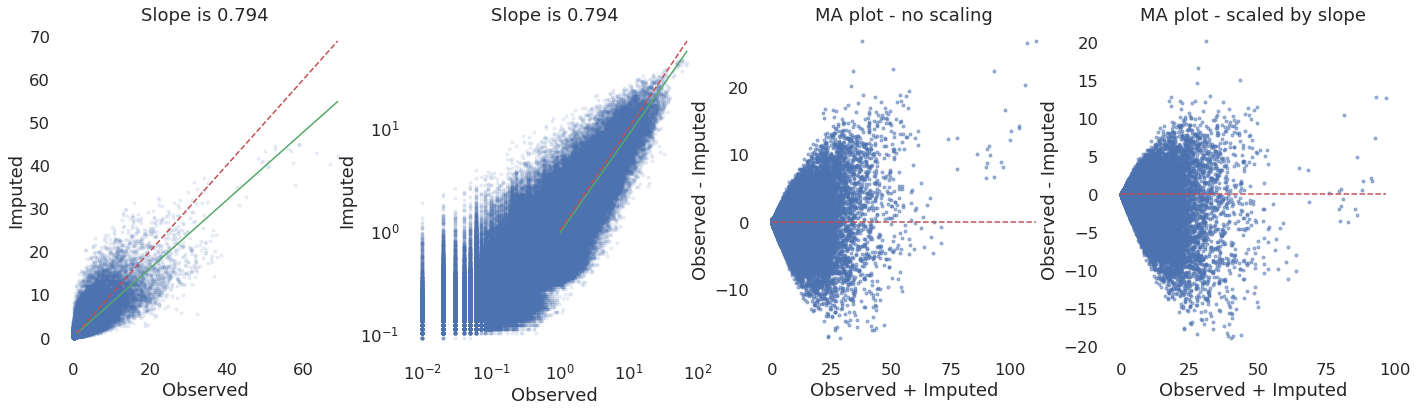

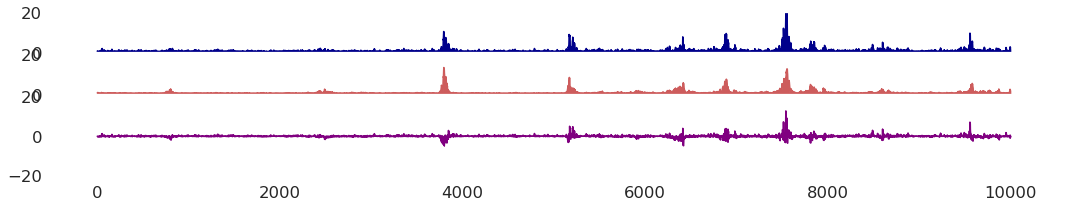

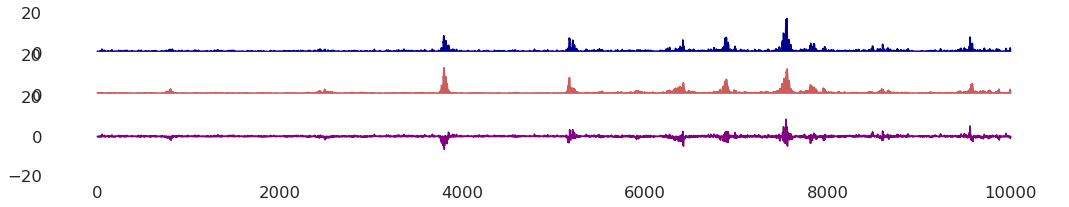

In [220]:
dataset = 2
obs = ad[dataset]
imp = ad[dataset + 1]
slope = plot_ma(obs, imp, range(int(2e6)), cut2=False)
plot_diff(obs, imp, start, 1e4, lim=20)
plot_diff(slope * obs, imp, start, 1e4, lim=20)